In [1]:
import pandas as pd
import numpy as np


In [4]:
# --------------- IMPORTS ----------------

# Data Handling Tools
import csv
import numpy as np
import math

# For clustering of stocks into sectors
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

# For making neural net models of indices
import torch
from torch import nn
from torch import optim

# For data visualisation
import matplotlib.pyplot as plt

# For random initialization of the trading strategy vector
import random


In [2]:
# Read in stock prices data
stock_prices = pd.read_csv('data_challenge_stock_prices.csv')

# Calculate daily returns in bps
stock_returns =stock_returns= 10000 * stock_prices.pct_change().dropna()
# Remove any stocks with missing or invalid data
stock_returns.dropna(axis=1, inplace=True)


Since the first two problem statements require us to find the partitioning of stocks into sectors with no other data than the returns, our first intuition was to find the correlation between them because:

we lacked any other information linking different stocks
we believed that different stocks of the same sector would exhibit high correlation due to similar market forces.
Below, we make an array of the pairwise correlations between stocks.

In [3]:
#covariance matrix for stock data to see relations b/w different stocks
correl = np.corrcoef(stock_returns.T)
correl.shape

(100, 100)

In [5]:
for i in range(100):
    for j in range(100):
        if i>j:
            correl[i][j]=correl[j][i]
        if i==j:
            correl[i][j]=1

At this point in time, we printed out the correlation values in a text file and did some rough analysing by hand. We noticed that certain pairs have correlations significantly above the average, indicating they probably come from the same sector. Also, the lack of any other data or basis for classification made us quite confident of our method.

Hence, we proceeded to cluster the stocks into groups via the fcluster method. Discussion of our clustering is given below the next code block.

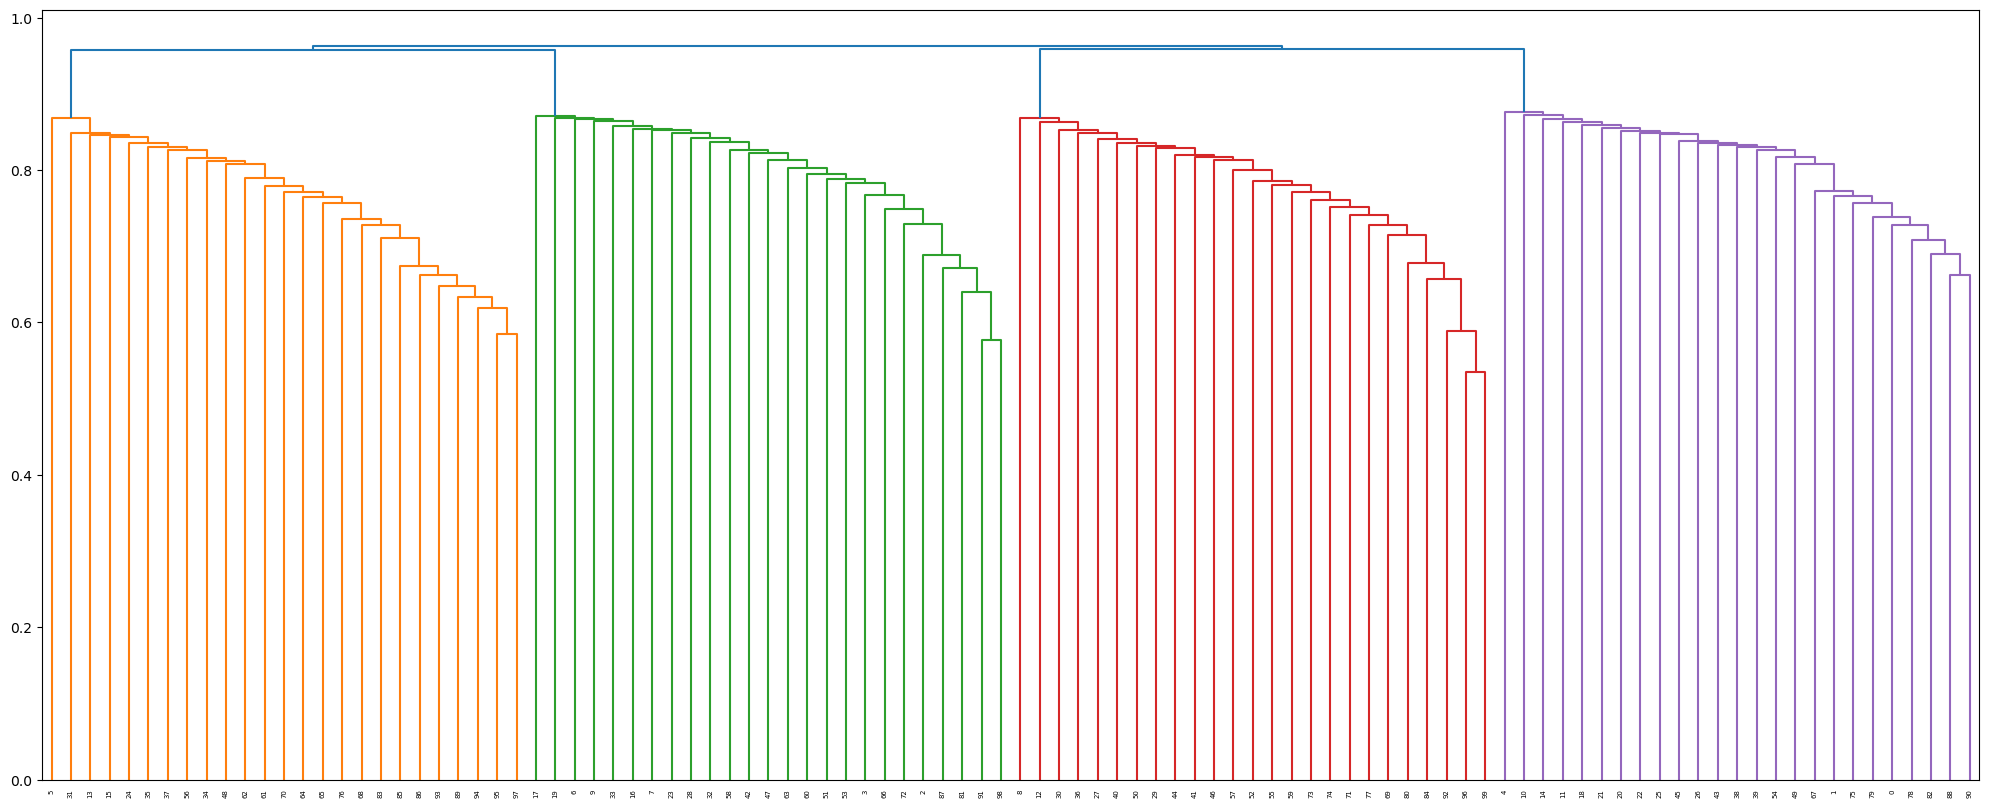

In [6]:
dissimilarity = 1 - correl
hierarchy = linkage(squareform(dissimilarity), method='average')
labels = fcluster(hierarchy, 0.9, criterion='distance')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(hierarchy, color_threshold=0.9)

for j in range(len(labels)):
    labels[j] -= 1 # to make the groups as 0,1,2,3 instead of 1,2,3,4 (convention :)

<h4>Solution to Problem Statement 1</h4>
We have found that the stocks in this world are divided into 4 distinct sectors. Further reasoning and explanation is given below.

We came up with the value of 0.9 for the parameter t by trying out multiple values and seeing the results. At values above this, the groups quickly merged into one, and at values below this, stocks started breaking off to form singleton groups. Throughout a large interval of t, there were 4 large groups, and as the dendrogram shows, the system of 4 groups was the most stable solution.

Below, we proceed to save the stock indices via group number.

In [8]:
clusters = dict()
for i in range(100):
    if labels[i] not in clusters:
        clusters[labels[i]] = [i]
    else:
        clusters[labels[i]].append(i)


for i in range(0, len(clusters)):
    print(i+1, clusters[i])

1 [5, 13, 15, 24, 31, 34, 35, 37, 48, 56, 61, 62, 64, 65, 68, 70, 76, 83, 85, 86, 89, 93, 94, 95, 97]
2 [2, 3, 6, 7, 9, 16, 17, 19, 23, 28, 32, 33, 42, 47, 51, 53, 58, 60, 63, 66, 72, 81, 87, 91, 98]
3 [8, 12, 27, 29, 30, 36, 40, 41, 44, 46, 50, 52, 55, 57, 59, 69, 71, 73, 74, 77, 80, 84, 92, 96, 99]
4 [0, 1, 4, 10, 11, 14, 18, 20, 21, 22, 25, 26, 38, 39, 43, 45, 49, 54, 67, 75, 78, 79, 82, 88, 90]


<h4>Solution to Problem Statement 2</h4>
The above output shows the partition of stocks into the 4 sectors (coincidentally, 25 stocks in each).

In the next 2 blocks, we verify the significant difference in correlations within the group and between groups.

In [9]:
def cross_rel(x, y):
    re = []
    for i in range(100):
        for j in range(100):
            if labels[i] == x and labels[j] == y:
                re.append(correl[i][j])

    return re

In [10]:
for p in range(4):
    for k in range(p+1):
        a = cross_rel(k,p)
        print(k, p, round(100*np.mean(a), 3))

0 0 23.033
0 1 4.213
1 1 20.151
0 2 4.055
1 2 3.569
2 2 21.842
0 3 3.608
1 3 3.79
2 3 4.06
3 3 19.534


As you can see above, there is a huge difference between in-group and cross-group correlations.

Below, we proceed to find the correlations between indices and stocks to help us solve problem statement 3, ie, find out which indices belong to which sectors. 

In [11]:
index_prices = pd.read_csv('data_challenge_index_prices.csv')
index_returns = 10000 * index_prices.pct_change().dropna()


We proceeded to write a method that helps us visualize these values, and hence, help us match index to sector.

In [12]:
stock_group_correl = [[0.0 for _ in range(15)] for _ in range(100)]
for i in range(100):
    for j in range(15):
        X = stock_returns.iloc[:, i]
        Y = index_returns.iloc[:, j]
        stock_group_correl[i][j] = np.corrcoef(X,Y)[0,1]

In [13]:
stock_group_correl=pd.DataFrame(stock_group_correl)

In [14]:
stock_group_correl

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.197164,0.011925,-0.058485,-0.012923,0.037764,-0.022474,0.044045,0.117845,0.021380,-0.016555,-0.006578,0.000755,0.002136,0.000443,-0.012787
1,0.184884,0.031376,-0.055909,-0.023980,0.017995,0.000766,0.027145,0.111110,0.022773,-0.003626,-0.012468,-0.000987,-0.004155,0.001335,-0.007522
2,0.038920,0.041111,-0.016871,-0.112598,0.037063,-0.012493,0.206965,0.022615,0.129083,-0.025359,-0.014392,0.001721,0.003526,-0.000485,-0.006766
3,0.015555,0.031571,0.000021,0.014465,0.024785,-0.002980,0.182327,0.019648,0.112655,-0.007290,-0.012095,-0.000372,0.001993,0.001318,-0.013886
4,0.167339,0.023881,-0.098800,-0.006712,0.035855,-0.012980,0.033407,0.131078,0.023220,-0.016241,-0.007371,-0.002628,-0.001416,0.000661,-0.010088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.022740,0.166392,-0.006209,-0.021626,0.042473,-0.091495,0.045466,0.018830,0.027914,-0.023343,-0.052430,-0.002244,0.003565,0.001665,-0.013940
96,0.050490,0.027560,-0.010689,-0.002281,0.269794,-0.014097,0.031372,0.029652,0.023882,-0.056814,-0.008322,0.001124,0.001825,-0.000489,-0.083045
97,0.068074,0.192537,-0.019385,-0.035854,0.064843,-0.102380,0.084071,0.045386,0.055723,-0.036207,-0.096673,-0.003488,0.003265,0.000507,-0.017934
98,0.073103,0.045562,-0.020370,-0.104887,0.057452,-0.027864,0.316909,0.049109,0.204988,-0.026822,-0.022461,-0.000351,0.003121,0.001790,-0.017849


In [15]:
def group_index_analyze(ind):
    arr = [[] for _ in range(4)]
    for cluster_no in range(4):
        for stock_no in range(25):
            arr[cluster_no].append(abs(stock_group_correl.iloc[clusters[cluster_no][stock_no]][ind]))
    for i in range(4):
        plt.scatter(list(range(25*i, 25*(i+1))), arr[i])
    plt.title(f"Index {ind}")
    plt.show()

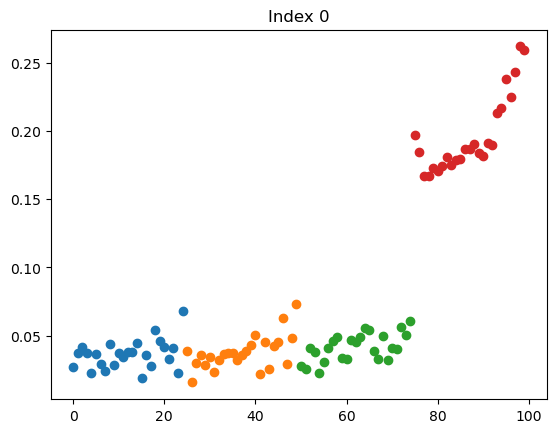

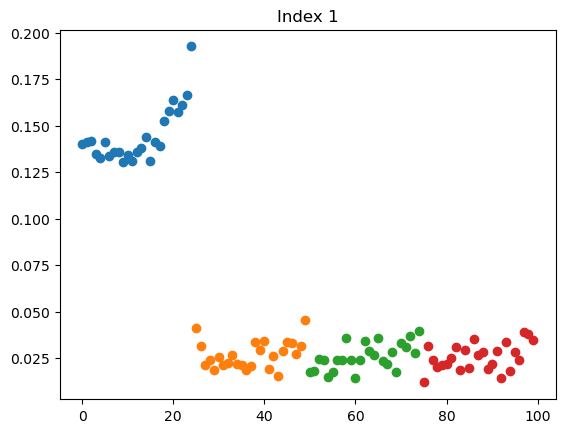

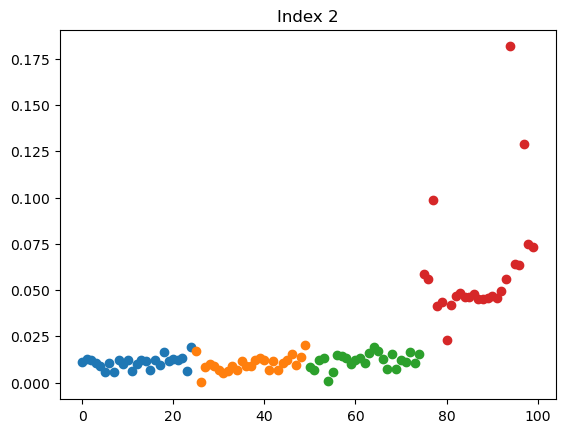

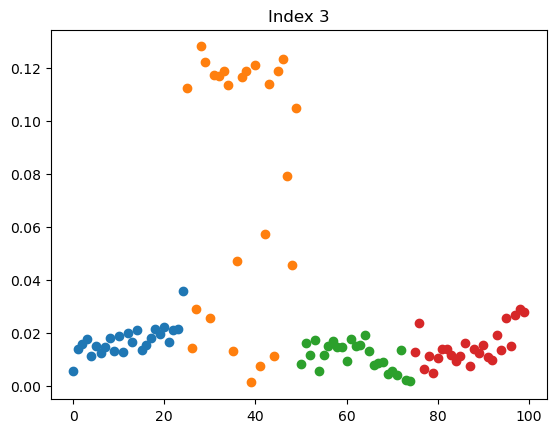

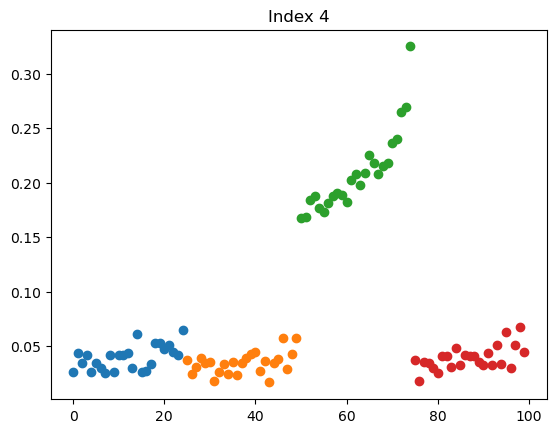

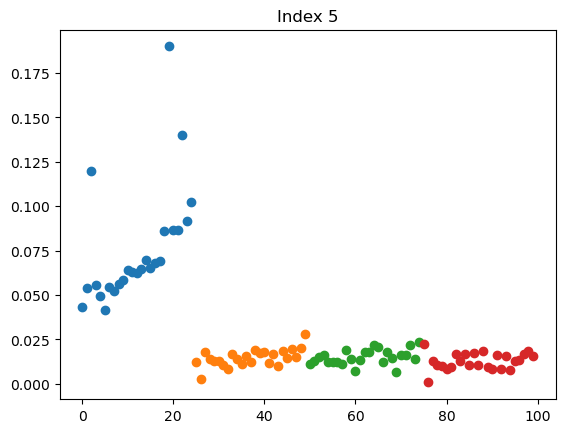

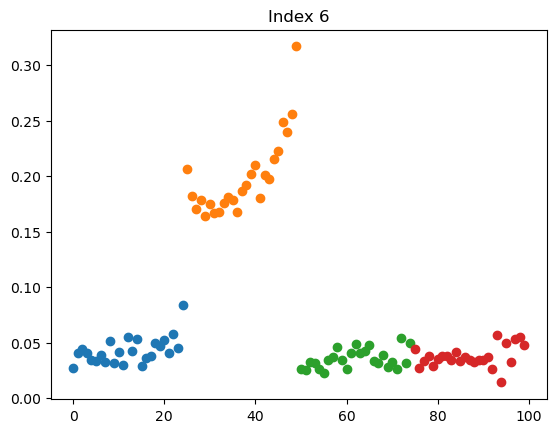

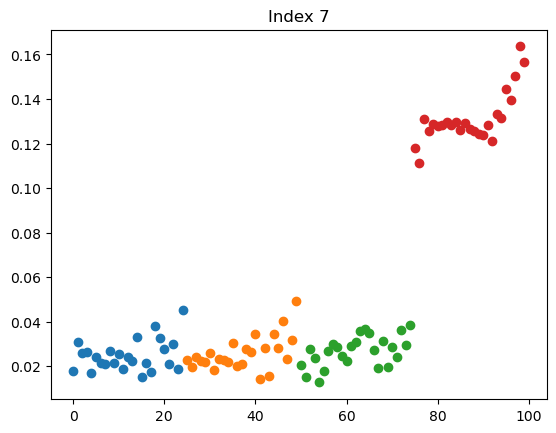

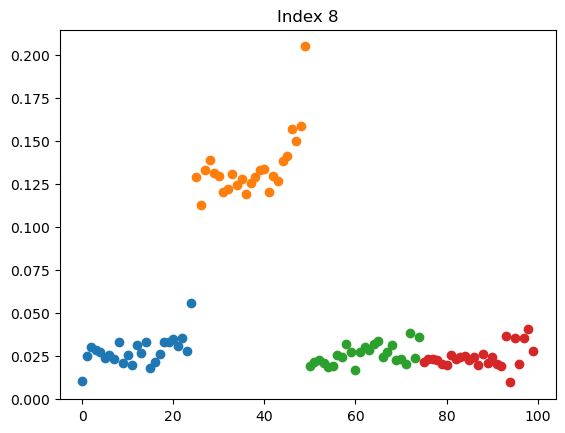

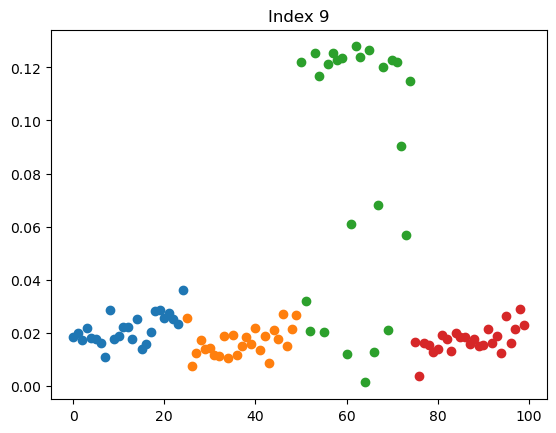

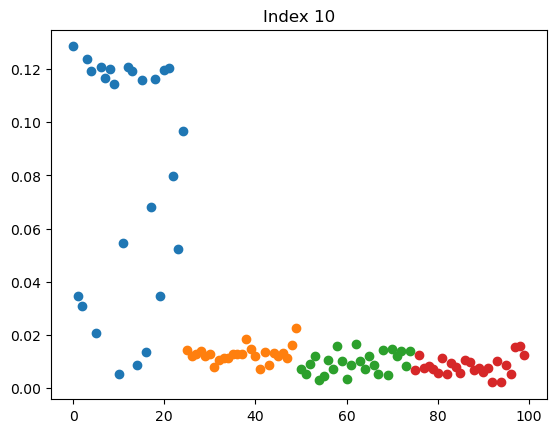

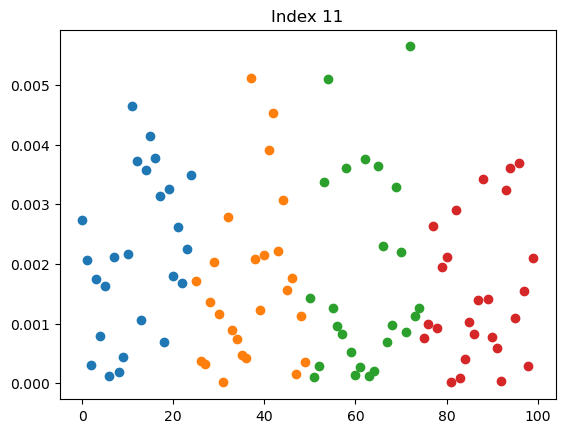

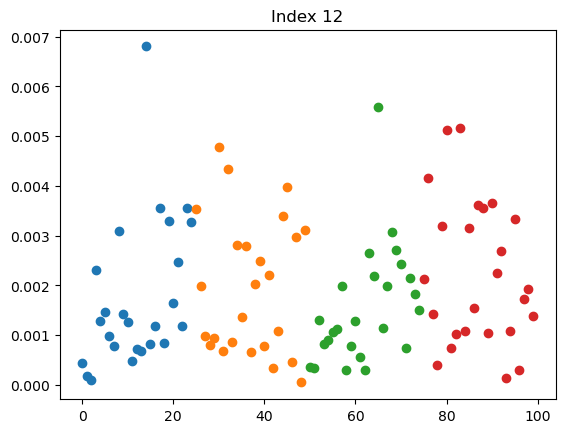

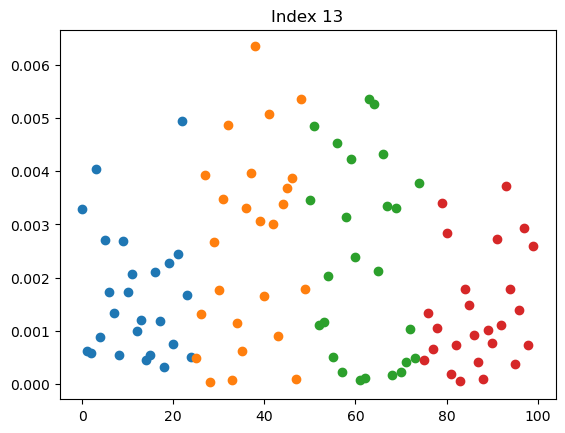

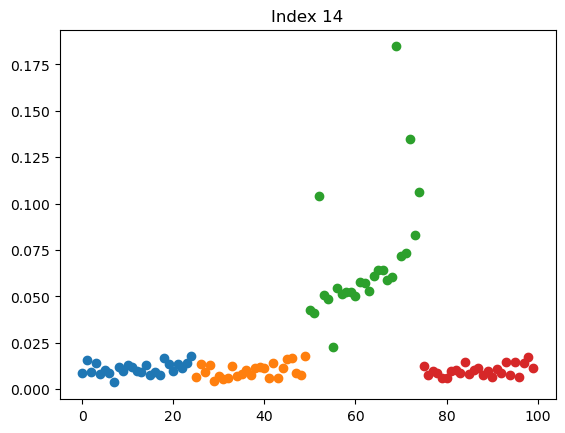

In [16]:
for i in range(15):
    group_index_analyze(i)

As you can see, these plots help us figure out the obvious index-sector matching for most indices. However, with indices 11, 12 and 13, there is no such clear inference. We will revisit this below.

For now, let us sort the stock returns data by group.

In [17]:
data=[]
for cluster_no in range(4):
    data1=[]
    for stock_no in range(25):
        data1.append(stock_returns.iloc[:,clusters[cluster_no][stock_no]])
    data1=np.transpose(data1)
    data.append(data1)


We decided to model our indices using neural nets. They are powerful universal function approximators, and amongst all the models we used (linear, quadratic regression, random forest, neural nets), gave the best results.

Discussion of our neural architecture below.

In [18]:
def make_model_for_index(index, data, epochs=10):

    batches = 200
    model = nn.Sequential(
        nn.Linear(25,64),
        nn.ReLU(), nn.Linear(64,256),
        nn.ReLU() ,nn.Linear(256,64),
        nn.ReLU() ,nn.Linear(64,1)
        )
    loss_func = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.001)

    data_tensor = torch.FloatTensor(data)
    batch_size = int(len(data)/batches)

    for e in range(epochs):
        for k in range(batches):
            optimizer.zero_grad()
            predicted = model(data_tensor[k*batch_size:(k+1)*batch_size, :])
            #print(torch.FloatTensor(index_returns.iloc[k*batch_size:(k+1)*batch_size,index]))
            actual = torch.unsqueeze(torch.FloatTensor(index_returns.iloc[k*batch_size:(k+1)*batch_size,index].values), 1)
            loss = loss_func(predicted, actual)
            loss.backward()
            optimizer.step()
    
    return model

We found the best architecture for our Neural Network by trial-and-error (not shown here). We observed that having 3 layers improved both the training and validation loss as compared to 2 layers, and adding an extra 4th layer worsened the validation loss due to overfitting of data. The number of neurons in each layer was determined by trying several variations. On smaller sizes, we had difficulty on indices 7 and 8, which gave predictive correlations < 40%. On making 256 neurons in one of the layers, we were finally able to estimate the function satisfactorily.

We tried several learning rates and settled on 0.001 because decreasing it further was significantly increasing the training time without much improvement on the results. We used weight_decay to reduce the overfitting noticed when we initially ran the model.

We proceeded to try fitting the ambiguous indices (11, 12, 13) on all 4 groups, and seeing if the neural nets could make sense of the data. See the results below for yourself:

In [19]:
for i in [11,12,13]:
    for j in [0,1,2,3]:
        m1 = make_model_for_index(i, data[j][:170000][:], epochs=30)
        predictions = np.array(torch.squeeze(m1(torch.FloatTensor(data[j][170000:][:])).detach()))
        res = (np.corrcoef(predictions,[index_returns.iloc[p,i] for p in range(170000, 199999)])[0,1])
        print(f"Correlation of neural net for index {i} modeled on sector {j} gives a predictive correlation of {round(100*res, 4)}%")
        

Correlation of neural net for index 11 modeled on sector 0 gives a predictive correlation of 0.4687%
Correlation of neural net for index 11 modeled on sector 1 gives a predictive correlation of -0.0696%
Correlation of neural net for index 11 modeled on sector 2 gives a predictive correlation of 1.3521%
Correlation of neural net for index 11 modeled on sector 3 gives a predictive correlation of 43.0742%
Correlation of neural net for index 12 modeled on sector 0 gives a predictive correlation of -0.1855%
Correlation of neural net for index 12 modeled on sector 1 gives a predictive correlation of -0.5288%
Correlation of neural net for index 12 modeled on sector 2 gives a predictive correlation of 43.096%
Correlation of neural net for index 12 modeled on sector 3 gives a predictive correlation of 1.3034%
Correlation of neural net for index 13 modeled on sector 0 gives a predictive correlation of 0.9593%
Correlation of neural net for index 13 modeled on sector 1 gives a predictive correlati

From the above output, it is obvious which sector the indices belong too. We had not figured out the functional form of said indices, but neural networks are a bit too overpowered!

In [20]:
index_to_group = [3,0,3,1,2,0,1,3,1,2,0,3,2,1,2]

The above array stores the index-sector matching. It is half the solution for the third problem statement.

In [21]:
index_models = [] # will contain models trained on first 170k samples, will verify on rest 30k
pred_correl = []

for i in range(15):
    index_models.append(make_model_for_index(i, data[index_to_group[i]][:170000][:], epochs=30))
    predictions = np.array(torch.squeeze(index_models[-1](torch.FloatTensor(data[index_to_group[i]][170000:][:])).detach()))
    pred_correl.append(np.corrcoef(predictions,[index_returns.iloc[p,i] for p in range(170000, 199999)])[0,1])
    print(i, 100*pred_correl[-1])

0 44.51320009437039
1 40.43817803004323
2 55.28568027979248
3 42.376013564011316
4 44.173980977078706
5 53.732077119625245
6 44.369889830175616
7 40.029765545693216
8 40.14889730048738
9 43.147630444137306
10 42.75918633738319
11 43.09151445552946
12 43.02961927187335
13 43.50592066700397
14 53.360389563997366


#### Solution to Problem Statement 3

As you can see above, the models we trained have >40% predictive correlation on data they never trained on. These models, stored in the index_models array, combined with their respective sectors stored in the index_to_group array, constitute the solutions to all 15 indexes. 

In [22]:
mu = []
for i in range(15):
    mu.append(np.array(torch.squeeze(index_models[-1](torch.FloatTensor(data[index_to_group[i]][:][:])).detach())))

mu = np.array(mu)

covar = np.cov(mu)

#### Solution to Problem Statement 4
We solved all indices (k=15) above. The 199999x15 array mu and the 15x15 array covar store the required predictions and covariance respectively. 

Note: The prediction matrix as given in the problem statement was supposed to be kxN in dimensions, however we have saved mu as its transpose (Nxk) because it better suits our purposes. 

The fifth problem statement lays out some requirements of an acceptable allocation for the trading strategy. The function below takes any allocation and enforces these conditions. It is handy to keep our allocations valid during our trading strategy, as you will see soon.

In [23]:
def normalize_alpha(A): # A is the 1-d array of allocations, we will use this function to satisfy 2nd and 3rd bullet points of 5th problem statement
    A = np.array(A)
    mn = A.mean()
    A = A - np.array([mn for _ in range(len(A))])
    mx = max(abs(A))
    for i in range(len(A)):
        A[i] /= mx

    return A

After trying numerous trading strategies (closed-form and optimization problems), we settled on the following optimization problem. The cost function takes the form of (predicted returns) - gamma * (total variance of investment).

gamma is a hyperparameter that we have tuned by trial-and-error. Maximising the cost function formulated above rewards returns and punishes highly variable investments. gamma controls the balance between both of these. We settled on a learning rate of 0.002 because anything larger gave very divergent/non-optimal solutions.

In [24]:
def Alpha(mu_t, covv): # takes Mu_t and covariance matrix and returns A (allocation)
    
    """-----------MAKE STRATEGY HERE---------------"""
    cst = 100
    old_cst = 200
    gamma = 0.13
    lr = 0.002

    A = np.array([random.random() for _ in range(15)])

    while( abs(cst - old_cst) > 0.001 ):
        A = normalize_alpha(A)
        old_cst = cst
        cst = np.dot(A,mu_t) - gamma * np.sum([[A[i]*A[j]*covv[i][j] for i in range(15)] for j in range(15)])
        
        grad = np.array([mu_t[g] - gamma * 2 * np.sum([covv[g][h] * A[h] for h in range(15)]) for g in range(15)])

        A = A + lr * grad




    """================ REMEMBER TO NORMALIZE===================="""

    A = normalize_alpha(A)

    return A


#### Solution to Problem Statement 5
The above function takes the predictions at a given time t and the covariance matrix, and returns an allocation scheme that satisfies the constraints given. 

In [32]:
trading_length = 5000

def test_Alpha(Alpha):
    day_ret = []

    for t in range(199999 - trading_length,199999):

        A = Alpha([mu[p][t] for p in range(15)], covar)
        actual_returns = [index_returns.iloc[t,p] for p in range(15)]
        day_ret.append(np.dot(A,actual_returns))

    day_ret = np.array(day_ret)

    print(f"Mean daily returns: {day_ret.mean()}")
    print(f"Standard deviation: {day_ret.std()}")
    print(f"Sharpe ratio: {day_ret.mean()/day_ret.std()}") 

    return day_ret

The testing scheme lets the strategy trade on days that it was not trained on, i.e., t>170k. The length of trading was adjusted based on speed and real-life constraints.

Since the trading involved is zero-sum, the risk-free rate of return (as required by the Sharpe Ratio formula) was assumed by us to be 0. Hence, the Sharpe ratio is simply the expected returns divided by their standard deviation. Also, we compute the cost function assuming the predictions to be perfect and the covariance as static, while it may actually change over time. However, these are reasonable assumptions that give an acceptable strategy.

In [37]:
r1 = test_Alpha(Alpha)

Mean daily returns: 0.7407152362269962
Standard deviation: 4.908139029729383
Sharpe ratio: 0.15091569976733862


<h4>Solution to Problem Statement 6</h4>


We have reported the mean returns, standard deviation and the sharpe of our trading strategy. Additionally, we have discussed the assumptions made, in the previous note.

Why we consider our trading strategy good:
Firstly, the all the 3 terms computed here are on a daily basis, hence they should not be compared to the industry-standard annualized Sharpe. Daily returns are smaller in magnitude and shorter time periods also have higher variance, hence our Sharpe is expected to be significantly lower.

For comparison, let us run one more allocation to establish a baseline for performance: a trivial one that allocates randomly.

Let us make and run this allocation on the same framework as before.

In [33]:
def Alpha_random(mu_t, covv): # takes Mu_t and covariance matrix and returns A (allocation)
    
    """-----------MAKE STRATEGY HERE---------------"""

    A = np.array([random.random() for _ in range(15)])

    """================ REMEMBER TO NORMALIZE===================="""

    A = normalize_alpha(A)

    return A


In [34]:
r2 = test_Alpha(Alpha_random)

Mean daily returns: 0.8541531470768677
Standard deviation: 4.849887500067727
Sharpe ratio: 0.17611813615572317


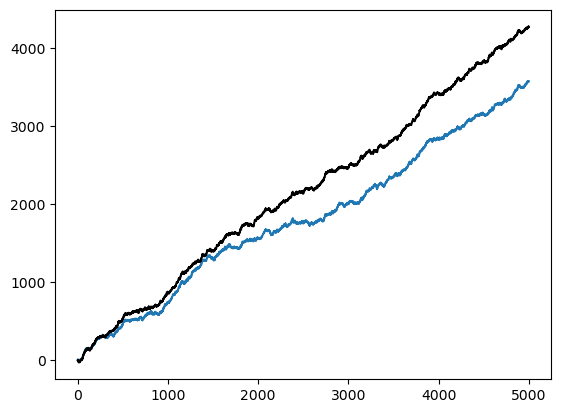

In [36]:
# simple visualisation of comparison between strategies
plt.plot(list(range(trading_length)), np.cumsum(r1))
plt.plot(list(range(trading_length)), np.cumsum(r2), color="000000")

plt.show()

Blue: Alpha() Black: Alpha_random()

As can be seen by the values of the Sharpe ratio and by the growth of the graphs, we can see that our strategy outperforms the random strategy. Hence we believe that in this imaginary world, our strategy is feasible and profitable.

